In [1]:
library(ggrepel)
library(magrittr)
library(cowplot)
library(tidyverse)
library(UpSetR)

palette <- c('HSIC Lasso' = '#c994c7', 'Block HSIC Lasso, B = 50' = '#df65b0',
             'Block HSIC Lasso, B = 20' = '#e7298a', 'Block HSIC Lasso, B = 10' = '#ce1256',
             'Block HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443', 'Raw' = 'gray70')
samples <-  c('100 samples', '1000 samples', '10000 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.0.1     ✔ purrr   0.3.0
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.3.1     ✔ stringr 1.3.1
✔ tibble  2.0.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ purrr::flatten()   masks jsonlite::flatten()
✖ cowplot::ggsave()  masks ggplot2::ggsave()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()


# Figure 1

In [2]:
fct_feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')
fct_causal <- c('5 causal', '10 causal', '20 causal')

methods <- c('HSIC Lasso', 'Block HSIC Lasso, B = 20',
             'mRMR', 'Block HSIC Lasso, B = 10',
             'LARS', 'Block HSIC Lasso, B = 5',  'Raw')

prepare_df <- function(x) {
    mutate(x,
           model = gsub('HSIC_lasso', 'HSIC Lasso', model),
           model = gsub('-B=0', '', model),
           model = gsub('HSIC Lasso-B=', 'Block HSIC Lasso, B = ', model),
           model = gsub('-M=3', '', model),
           model = factor(model, levels = methods),
           samples_txt = factor(paste(samples, 'samples')),
           causal_txt = factor(paste(causal, 'causal'), levels = fct_causal),
           features_txt = factor(paste(features, 'features'), levels = fct_feats)) %>%
    group_by(model, samples, features, causal, samples_txt, features_txt, causal_txt) 
}

features <- read_tsv('../results/benchmark/random_feature_selection.tsv', 
                     col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup

options(repr.plot.width=8, repr.plot.height=8)
fig1 <- ggplot(features, aes(x = features, y = tpr, color = model)) +
    geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
    geom_point() +
    geom_line() +
    theme_linedraw() +
    theme(legend.position = 'bottom',
          panel.grid.minor = element_blank()) + 
    labs(x = '# features', y = '% true features', color = 'Algorithm') +
    facet_grid(causal_txt ~ samples_txt) + 
    scale_y_continuous(labels = scales::percent) +
    scale_color_manual(values = palette) + 
    guides(color = guide_legend(nrow = 3, byrow = TRUE, keyheight=0.1))

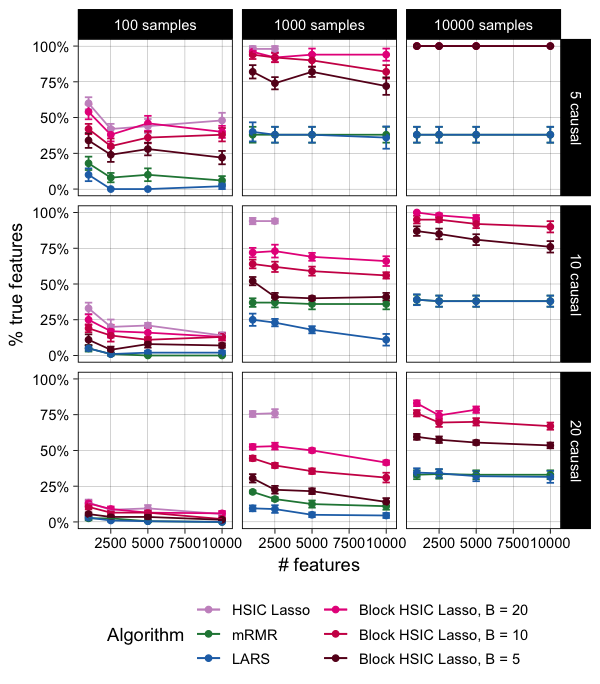

In [3]:
ggsave('img/Climente-Gonzalez.11.fig.1.pdf', fig1, width = 5, height = 5.7)
options(repr.plot.width = 5, repr.plot.height = 5.7)
fig1

# Figure 2

In [4]:
parse_deltatime <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('ms', x)) {
            x <- gsub('ms', '', x) %>% as.numeric
            x <- x / 1000
        } else if (grepl('s', x)) {
            x <- gsub('s', '', x) %>% as.numeric
        } else if (grepl('m', x)) {
            x <- gsub('m', '', x) %>% as.numeric
            x <- x * 60
        } else if (grepl('h', x)) {
            x <- gsub('h', '', x) %>% as.numeric
            x <- x * 3600
        } else {
            x <- NA
        }

        return(x)
        
    }
    
    strsplit(column, ' ') %>% lapply(function(x) lapply(x, parse_subfield) %>% unlist) %>% lapply(sum) %>% unlist
   
}
                                     
parse_memory <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('MB', x)) {
            x <- gsub(' MB', '', x) %>% as.numeric
        } else if (grepl(' GB', x)) {
            x <- gsub(' GB', '', x) %>% as.numeric
            x <- x * 1000
        } else {
            x <- NA
        }

        return(x)
        
    }
    
    lapply(column, parse_subfield) %>% unlist
   
}
                                     
read_trace <- function(tracefile) {
    
    methods <- c('HL', 'Block HL, B = 20',
             'Block HL, B = 10', 'Block HL, B = 5', 
             'mRMR', 'LARS', 'Raw')
    
    read_tsv(tracefile, col_types = 'cccccccccccccc') %>%
        mutate(time_s = parse_deltatime(realtime),
               memory_mb = parse_memory(vmem),
               task = gsub(' .+', '', name) %>% gsub('run_', '', .) %>% toupper,
               causal = gsub('.+[^0-9] \\(', '', name) %>% gsub(',.+', '', .),
               B = gsub('.+ B = ', '', name) %>% gsub(',? .+', '', .),
               M = gsub('.+ M = ', '', name) %>% gsub(' .+', '', .)) %>% 
        filter(task %in% c('HSIC_LASSO', 'LARS', 'MRMR')) %>%
        mutate(task = ifelse(task == 'HSIC_LASSO', 'HL', task),
               task = ifelse(task == 'MRMR', 'mRMR', task),
               task = ifelse(task == 'HL' & B != '0', paste0('Block ', task, ', B = ', B), task),
               task = factor(task, levels = methods))
    
}

In [5]:
runtime <- read_trace('../results/benchmark/trace.txt')
memory <- read_trace('../results/resources/resources_trace.txt')

palette_comp <- c('HL' = '#c994c7', 
                  'Block HL, B = 20' = '#e7298a', 
                  'Block HL, B = 10' = '#ce1256',
                  'Block HL, B = 5' = '#67001f',
                  'LARS' = '#2171b5', 'mRMR' = '#238443')
m_palette <- c('1' = '#c7e9b4', '2' = '#7fcdbb', '3' = '#41b6c4', 
               '4' = '#1d91c0', '5' = '#225ea8', '10' = '#0c2c84')

runtime_plt <- ggplot(runtime, aes(x = task, y = time_s, fill = task)) +
        geom_boxplot() +
        scale_y_log10() +
        labs(y = 'Time (s)', x = '') +
        scale_fill_manual(values = palette_comp) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
              legend.position = 'none')

memory_plt <- ggplot(memory, aes(x = task, y = memory_mb, fill = task)) +
        geom_boxplot() +
        scale_y_log10() +
        labs(y = 'Memory (MB)', x = '') +
        scale_fill_manual(values = palette_comp) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
              legend.position = 'none')

accuracy_b_m <- read_tsv('../results/resources/stability_feature_selection.tsv', 
                         col_types = 'ciiiiid') %>%
    mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
           B = gsub('.+-B=', '', model),
           B = gsub('-M.+', '', B),
           M = gsub('.+-M=', '', model),
           model = gsub('-B.+', '', model)) %>%
    group_by(model, B, M, samples, features, causal) %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup %>%
    filter(model == 'HSIC Lasso') %>%
    mutate(B = as.integer(B),
           M = factor(M, levels = unique(sort(as.integer(M))))) %>%
    ggplot(aes(x = B, y = tpr, color = M)) +
        geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 1) +
        geom_point() +
        geom_line() +
        theme_linedraw() +
        theme(legend.position = 'bottom') + 
        labs(y = '% true features') +
        scale_x_continuous(breaks = c(5,10,15,30,60)) +
        scale_y_continuous(labels = scales::percent) +
        scale_color_manual(values = m_palette)

computations <- plot_grid(runtime_plt, memory_plt, accuracy_b_m, labels = c('A', 'B', 'C'), 
                          nrow = 1, rel_widths = c(1,1,1.2))

Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”

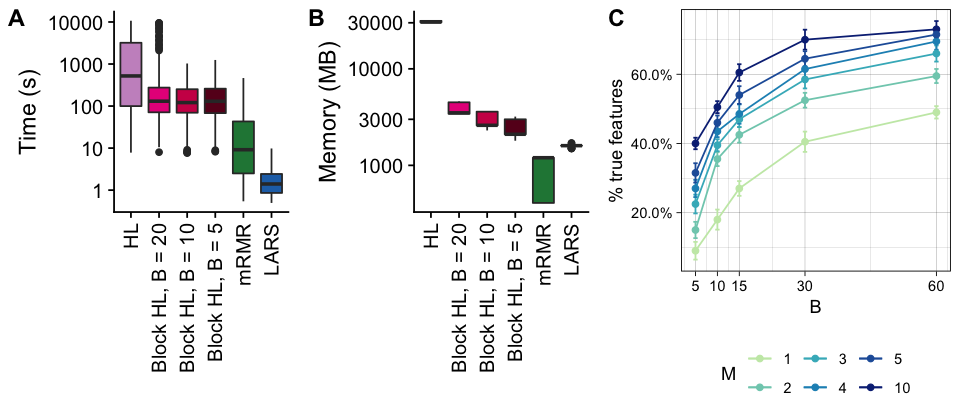

In [6]:
ggsave('img/Climente-Gonzalez.11.fig.2.pdf', computations, width = 8, height = 3.5)
options(repr.plot.width=8, repr.plot.height=3.5)
computations

# Figure 3

In [7]:
summarize_benchmark <- function(x) {
    
    label <- strsplit(x, '/') %>% unlist %>% .[4] %>% gsub('_prediction.tsv', '', .)
    methods <- c('HSIC Lasso', 'mRMR',
                 'Block HSIC Lasso, B = 10', 'LARS', 
                 'Block HSIC Lasso, B = 5', 'Raw')
    
    read_tsv(x, col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('HSIC Lasso-B=', 'Block HSIC Lasso, B = ', model),
               model = gsub('-M=3', '', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy) / sqrt(ended), accuracy = mean(accuracy) ) %>%
        ungroup %>%
        mutate(label = label)

}

CLLSUB111 <- summarize_benchmark('../results/asu/CLL-SUB-111_prediction.tsv')
tox171 <- summarize_benchmark('../results/asu/TOX-171_prediction.tsv')
glioma <- summarize_benchmark('../results/asu/GLIOMA_prediction.tsv')
smkcan187 <- summarize_benchmark('../results/asu/SMK_CAN_187_prediction.tsv')

methods <- c('HSIC Lasso', 'mRMR',
             'Block HSIC Lasso, B = 10', 'LARS', 
             'Block HSIC Lasso, B = 5', 'Raw')

prediction_ma <- bind_rows(CLLSUB111, tox171, glioma, smkcan187) %>%
    mutate(model = factor(model, levels = methods))

ma <- prediction_ma %>%
    filter(model != 'Raw') %>%
    ggplot(aes(x = selected, y = accuracy, color = model)) +
        geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
        geom_point() +
        geom_line() +
        geom_hline(data = filter(prediction_ma, model == 'Raw'), 
                   aes(yintercept = accuracy), colour = 'gray20', alpha = 0.5) +
        theme_linedraw() +
        theme(text = element_text(size=9),
              legend.position = 'bottom',
              axis.text.x = element_text(angle = 45, hjust = 1),
              panel.grid.minor = element_blank()) + 
        labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Algorithm') +
        scale_color_manual(values = palette) +
        facet_wrap(~label, nrow = 2) + 
        guides(color = guide_legend(nrow = 3, byrow = TRUE, keyheight=0.1))

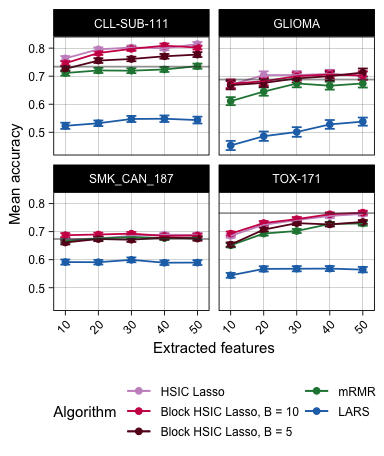

In [8]:
ggsave('img/Climente-Gonzalez.11.fig.3.pdf', ma, width = 3.2, height = 3.7)
options(repr.plot.width = 3.2, repr.plot.height = 3.8)
ma

# Figure 4

In [9]:
manhattan <- function(pheno) {
    
    results <- '../results/gwas/' 
    
    map <- read_tsv('../results/gwas/t1d/controls.bim',
                    col_names = F, col_types = 'iciiii') %>%
           set_colnames(c('chr', 'snp', 'cm', 'pos', 'x1', 'x2')) %>%
           select(-cm, -x1, -x2)
    
    snp2gene <- read_tsv(paste0(results, 'snp2hgnc.tsv'), 
                     col_types = 'cc')
    
    selected <- read_tsv(paste0(results, pheno, '/', pheno, 
                                '_hsic_lasso_C=10_SELECT=50_M=1_B=60.txt'), 
                     col_names = F, col_types = 'c') %>%
        head(10) %>%
        set_colnames('snp') %>%
        .$snp
    
    gwas <- read_tsv(paste0(results, pheno, '/univariate_models.tsv'),
                     col_types = 'icddcccd') %>%
        rename(chr = CHR, snp = SNP) %>%
        filter(TEST == 'GENO') %>%
        inner_join(map, by = c('chr', 'snp')) %>%
        mutate(selected = ifelse(snp %in% selected, 'Yes', 'No'),
               P = P + 1e-220) %>%
        arrange(selected)

    don <- gwas %>% 

      # Compute chromosome size
      group_by(chr) %>% 
      summarise(chr_len=max(pos)) %>% 

      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(chr_len)-chr_len) %>%
      select(-chr_len) %>%

      # Add this info to the initial dataset
      left_join(gwas, ., by='chr') %>%

      # Add a cumulative position of each SNP
      arrange(chr, pos) %>%
      mutate( BPcum=pos+tot) %>%
      left_join(arrange(snp2gene, symbol) %>% group_by(snp) %>% summarize(symbol = head(symbol, 1)), by = 'snp')

    bf_threshold <- .05 / nrow(gwas)
    y_lim <- max(-log10(don$P), na.rm = TRUE) + 15
    axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

    ggplot(don, aes(x=BPcum, y=-log10(P))) +

        # Show all points
        geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
        geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P)), color = 'black') +
        scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

        # Add Bonferroni line
        geom_hline(yintercept = -log10(bf_threshold), color = 'red') +
    
        # add gene symbols
        geom_text_repel(data = filter(don, selected == 'Yes' & !is.na(symbol)), 
                        aes(x=BPcum, y=-log10(P), label = symbol)) +

        # custom X axis:
        scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
        scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

        # Custom the theme:
        theme_bw() +
        theme( 
          legend.position="none",
          panel.border = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        ) +
        labs(x = 'Chromosome', y = bquote('-log' [10] ~'(p-value)'))
    
}

In [10]:
t1d_plt <- manhattan('t1d')
t2d_plt <- manhattan('t2d')
ra_plt <- manhattan('ra')

manhattan <- plot_grid(t1d_plt, t2d_plt, ra_plt, nrow = 3,
                       labels = c('T1D', 'T2D', 'RA'))

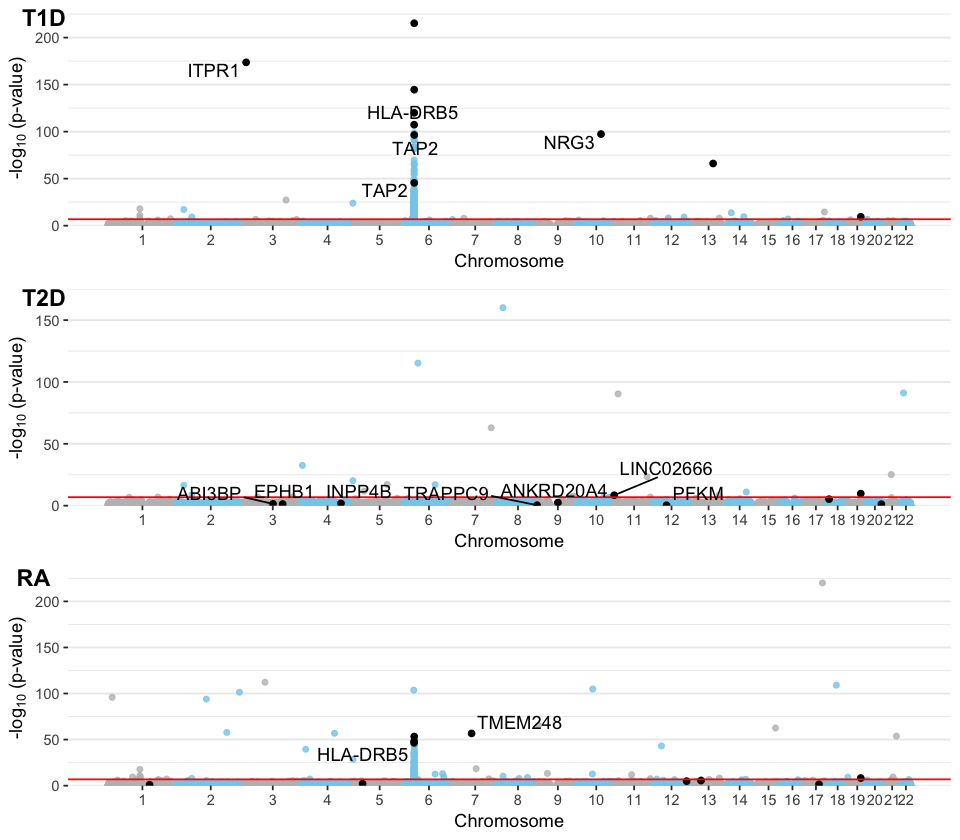

In [11]:
ggsave('img/Climente-Gonzalez.11.fig.4.png', manhattan, width = 8, height = 7)
ggsave('img/Climente-Gonzalez.11.fig.4.pdf', manhattan, width = 8, height = 7)
options(repr.plot.width=8, repr.plot.height=7)
manhattan